In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

#from utils import read_mtx
from plot import plot_embedding, plot_clustercounts

%matplotlib inline

In [89]:
hema=pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', 
                 sep='\t',header=0, index_col=-1)

In [40]:
np.unique(hema['Group'])

array(['BM_pDC', 'B_Cells', 'Bone_Marrow_Rep1', 'CD34_Progenitors_Rep1',
       'CD34_Progenitors_Rep2', 'CD4_HelperT', 'CLP', 'CMP',
       'Dendritic_Cells', 'GMP', 'HSC', 'LMPP', 'MEP', 'MPP',
       'Memory_CD4_T_Cells_Rep1', 'Memory_CD4_T_Cells_Rep2',
       'Memory_CD8_T_Cells', 'Monocytes', 'NK_Cells',
       'Naive_CD4_T_Cells_Rep1', 'Naive_CD4_T_Cells_Rep2',
       'Naive_CD8_T_Cells', 'PBMC_Rep1', 'PBMC_Rep2', 'PBMC_Rep3',
       'PBMC_Rep4', 'Regulatory_T_Cells'], dtype=object)

In [127]:
hema.shape

(63882, 8)

In [8]:
hema.head(3)

,UMAP1,UMAP2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name
Group_Barcode,,,,,,,,
Bone_Marrow_Rep1#CAAGAAAGTCAAGACG-1,-2.419656,7.603472,Cluster6,Bone_Marrow_Rep1,29301,0.347190,CAAGAAAGTCAAGACG-1,SUHealthy_BM_B1_50
Bone_Marrow_Rep1#AATGCCATCGCACAAT-1,5.676727,-9.210454,Cluster20,Bone_Marrow_Rep1,7534,0.290948,AATGCCATCGCACAAT-1,SUHealthy_BM_B1_51
Bone_Marrow_Rep1#AAAGGGCAGTACCCAT-1,-7.153399,-5.512960,Cluster11,Bone_Marrow_Rep1,29608,0.449186,AAAGGGCAGTACCCAT-1,SUHealthy_BM_B1_52


In [75]:
cluster_anno=pd.read_csv('data/Hematopoiesis-All/Hematopoiesis-All_cluster.txt', sep='\t', header=None, index_col=0)
cluster_anno=cluster_anno[1].to_dict()
hema['ClusterName']=hema.apply(lambda x: cluster_anno[x['Clusters']], axis=1)

# clustering

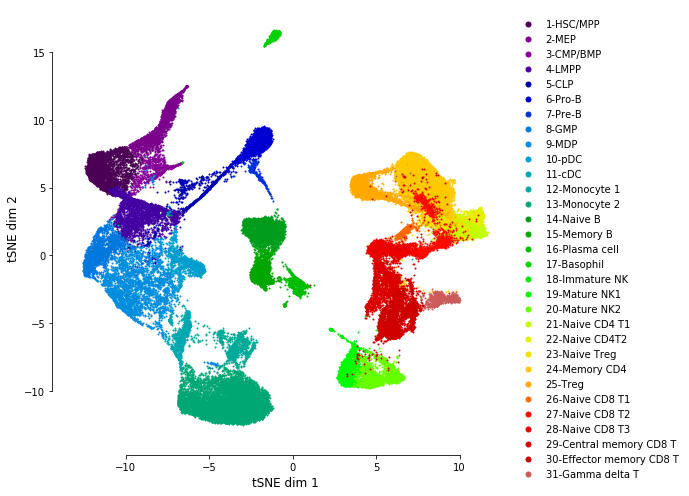

In [70]:
plot_embedding(np.array(hema[['UMAP1','UMAP2']]), hema['ClusterName'], classes=cluster_anno.values(),
               cmap='nipy_spectral', figsize=(8,8),markersize=1)

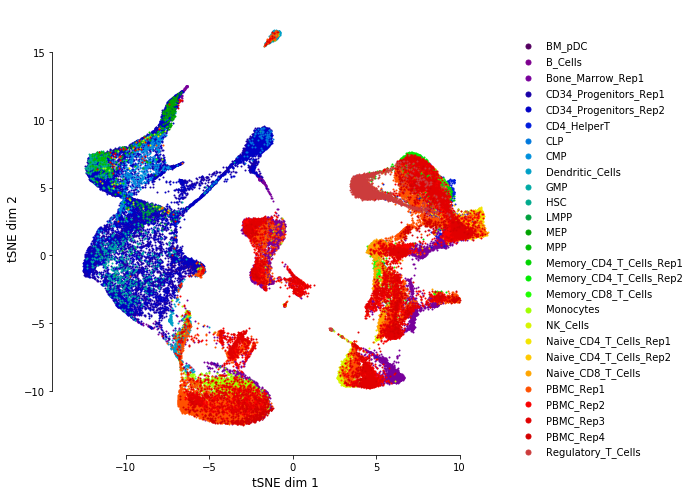

In [42]:
plot_embedding(np.array(hema[['UMAP1','UMAP2']]), hema['Group'], 
               cmap='nipy_spectral', figsize=(8,8),markersize=1)

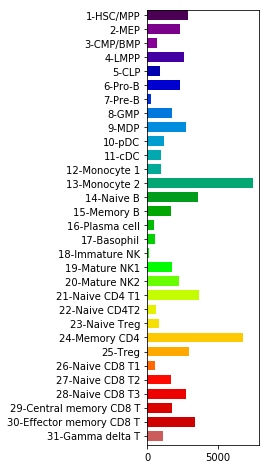

In [99]:
cluster_counts=hema['ClusterName'].value_counts()
cluster_counts=cluster_counts.loc[cluster_anno.values()]
plot_clustercounts(cluster_counts,clusters=list(cluster_anno.values()), 
                   cmap='nipy_spectral',width=0.7,figsize=(2,8),yticks=True)

In [ ]:
adata=read_anndata('data/Hematopoiesis-All/data/')

In [ ]:
adata.obs['clusters']=hema['ClusterName'].values

In [146]:
adata.write('data/Hematopoiesis-All/adata.h5ad')

... storing 'clusters' as categorical


In [3]:
adata=sc.read_h5ad('data/Hematopoiesis-All/adata.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 63882 × 571400 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'clusters'
    uns: 'rank_genes_groups'

In [12]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [13]:
adata.write('data/Hematopoiesis-All/adata.h5ad')

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, standard_scale='var') # MemoryError

# specific features

In [40]:
from plot import plot_heatmap

In [77]:
adata=sc.read_h5ad('result/Hematopoiesis-All/Hematopoiesis-All_adata.h5ad')
specific_genes=pd.DataFrame(adata.uns['rank_genes_groups']['names']).loc[0:20,:].T.values.flatten()
X2=pd.DataFrame(adata[:,specific_genes].X.todense()).T
X2.index=specific_genes
X2.columns=adata.obs['clusters'].values
X2_group=X2.T
X2_group['clusters']=X2_group.index
X2_group=X2_group.groupby('clusters').mean().T
X2=X2_group

In [78]:
y_cluster=np.array([el.split('-')[0] for el in X2.columns])
X2.columns=y_cluster

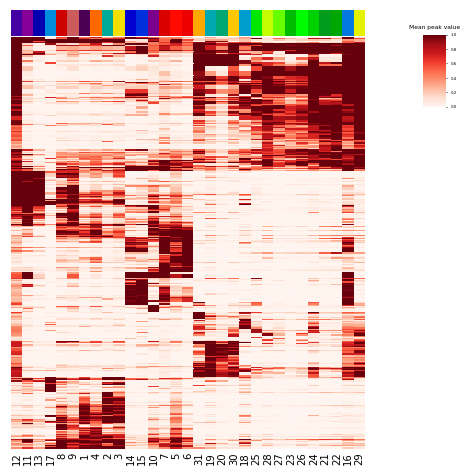

In [41]:
plot_heatmap(X2, y=y_cluster, ncol=3, #row_labels=specific_genes, 
               cmap='Reds' ,colormap=sns.color_palette('nipy_spectral', n_colors=len(y_cluster)),
             vmax=1, row_cluster=True, col_cluster=True,
                 legend_font=6, cax_title='Mean peak value',show_legend=False,
                figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(1, 0.6, .04, .1),
                save=None)

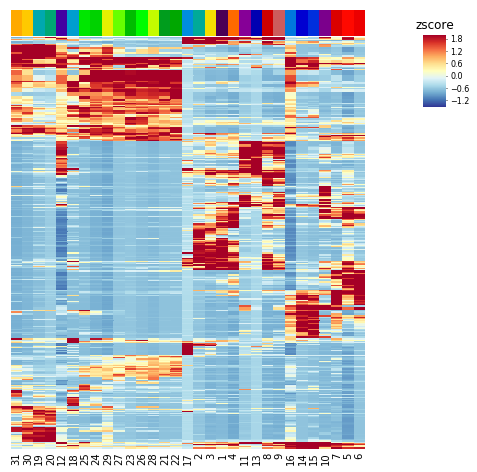

In [86]:
col_colors=sns.color_palette('nipy_spectral', n_colors=len(y_cluster))

plot_heatmap(X2, y=y_cluster, ncol=3, vmax=2, vmin=-1.5,
             row_cluster=True, col_cluster=True, 
             z_score=1, cmap='RdYlBu_r',
             colormap=sns.color_palette('nipy_spectral', n_colors=len(y_cluster)),
            legend_font=6, cax_title='zscore',show_legend=False,
            figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(1, 0.6, .04, .1), 
             save=None)

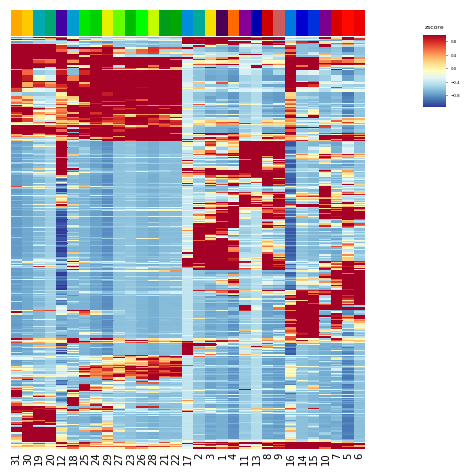

In [55]:
col_colors=sns.color_palette('nipy_spectral', n_colors=len(y_cluster))

plot_heatmap(X2, y=y_cluster, ncol=3, vmax=1, # cluster sorted by class
             row_cluster=True, col_cluster=True, 
             z_score=1, cmap='RdYlBu_r',
             colormap=col_colors,
            legend_font=6, cax_title='zscore',show_legend=False,
            figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(1, 0.6, .04, .1), 
             save='specific_peaks.png')

# TF enrichment

In [24]:
from plot import plot_heatmap

In [6]:
tfdata=pd.read_csv('result/Hematopoiesis-All/chromVAR_f/hema_all_f_dev.txt', sep='\t', header=0, index_col=0)
tfdata.index=[el.split('_')[-1] for el in tfdata.index]
tfdata=sc.AnnData(tfdata.T)

In [7]:
# raw adata is filtered for lack of memory size when running chromVAR
filtered_cells=pd.read_csv('data/Hematopoiesis-All/data_filtered/barcodes.txt', header=None, index_col=0).index

In [ ]:
cluster_anno=pd.read_csv('data//Hematopoiesis-All/Hematopoiesis-All_cluter.txt', sep='\t', header=None, index_col=0)
cluster_anno=cluster_anno[1].to_dict()
hema=pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', 
                 sep='\t',header=0, index_col=-1)
hema['ClusterName']=hema.apply(lambda x: cluster_anno[x['Clusters']], axis=1)

In [10]:
tfdata.obs_names=list(filtered_cells)
tfdata.obsm['X_umap']=np.array(hema[['UMAP1','UMAP2']].loc[tfdata.obs_names,])
tfdata.obs['cluster']=hema['ClusterName'].loc[tfdata.obs_names]

<Figure size 1080x288 with 0 Axes>

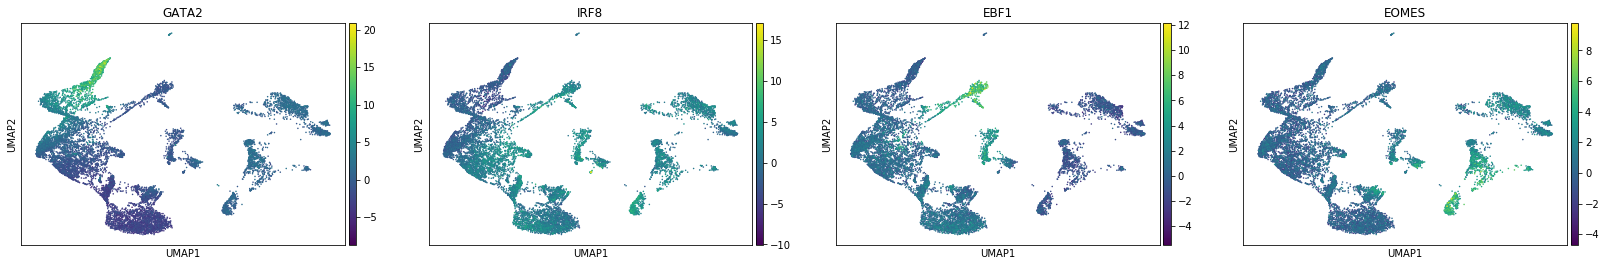

In [51]:
plt.figure(figsize=(15,4))
sc.pl.umap(tfdata, color=['GATA2','IRF8', 'EBF1','EOMES'])#, color_map='nipy_spectral'

In [3]:
# plot heatmap
## choose 250 most variable TFs
var = pd.read_csv('result/Hematopoiesis-All/chromVAR_f/hema_all_f_var.txt', sep='\t', header=0, index_col=0)
var = var [var['p_value_adj']<0.05]
var_sort = var.sort_values(by='variability',ascending=False)
tf_filtered = [el.split('_')[-1] for el in var_sort.index][:250]
tfdata_f = tfdata[:,tf_filtered]

In [87]:
y_cluster=tfdata_f.obs['cluster'].values
X=pd.DataFrame(tfdata_f.X.T, index=tfdata_f.var_names, columns=tfdata_f.obs_names)

In [39]:
np.unique(y_cluster)

array(['1-HSC/MPP', '10-pDC', '11-cDC', '12-Monocyte 1', '13-Monocyte 2',
       '14-Naive B', '15-Memory B', '16-Plasma cell', '17-Basophil',
       '18-Immature NK', '19-Mature NK1', '2-MEP', '21-Naive CD4 T1',
       '22-Naive CD4T2', '23-Naive Treg', '24-Memory CD4', '25-Treg',
       '26-Naive CD8 T1', '27-Naive CD8 T2', '28-Naive CD8 T3',
       '29-Central memory CD8 T', '3-CMP/BMP', '30-Effector memory CD8 T',
       '31-Gamma delta T', '4-LMPP', '5-CLP', '6-Pro-B', '7-Pre-B',
       '8-GMP', '9-MDP'], dtype=object)

In [49]:
X.max().max()

26.690168380737305

In [50]:
X.min().min()

-28.121309280395508

In [88]:
col_cluster=sns.color_palette('nipy_spectral', n_colors=len(y_cluster))
classes = list(cluster_anno.values())

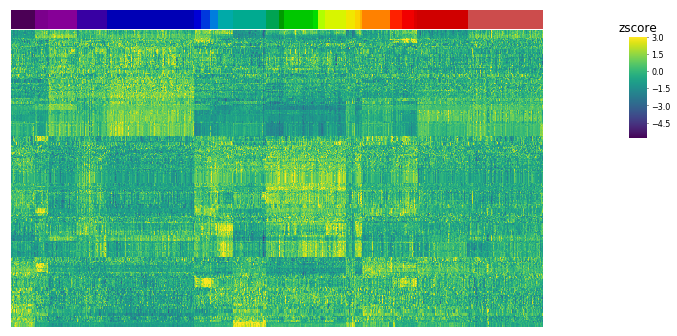

In [90]:
plot_heatmap(X, y_cluster, ncol=3, vmax=3, #vmin=-5,
             row_cluster=True, col_cluster=False, 
             xticklabels=False,
             z_score=0, 
             #cmap='RdYlBu_r',
             #cmap='Spectral',
             cmap='viridis',
             #cmap='inferno',
             colormap=sns.color_palette('nipy_spectral', n_colors=len(np.unique(y_cluster))),
            legend_font=6, cax_title='zscore',show_legend=False,
            figsize=(12, 7), bbox_to_anchor=(0.4, 1.2), position=(1, 0.5, .02, .2), 
             save='result/Hematopoiesis-All/chromVAR_f/dev_heatmap.png')

# cicero gene activity

In [1]:
from utils import read_mtx,read_anndata
import scanpy as sc
import pandas as pd
import numpy as np

In [4]:
hema=pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', 
                 sep='\t',header=0, index_col=-1)

In [2]:
ga = read_anndata('result/Hematopoiesis-All/cicero/ciceroGA/')

In [5]:
#
ga.obs=hema.loc[ga.obs_names,:]
ga.obsm['X_umap']=np.array(hema[['UMAP1','UMAP2']].loc[ga.obs_names,])

In [22]:
newX=ga.X.todense()
newX=np.log2(newX*1000000+1)

In [23]:
newga=ga
newga.X=newX

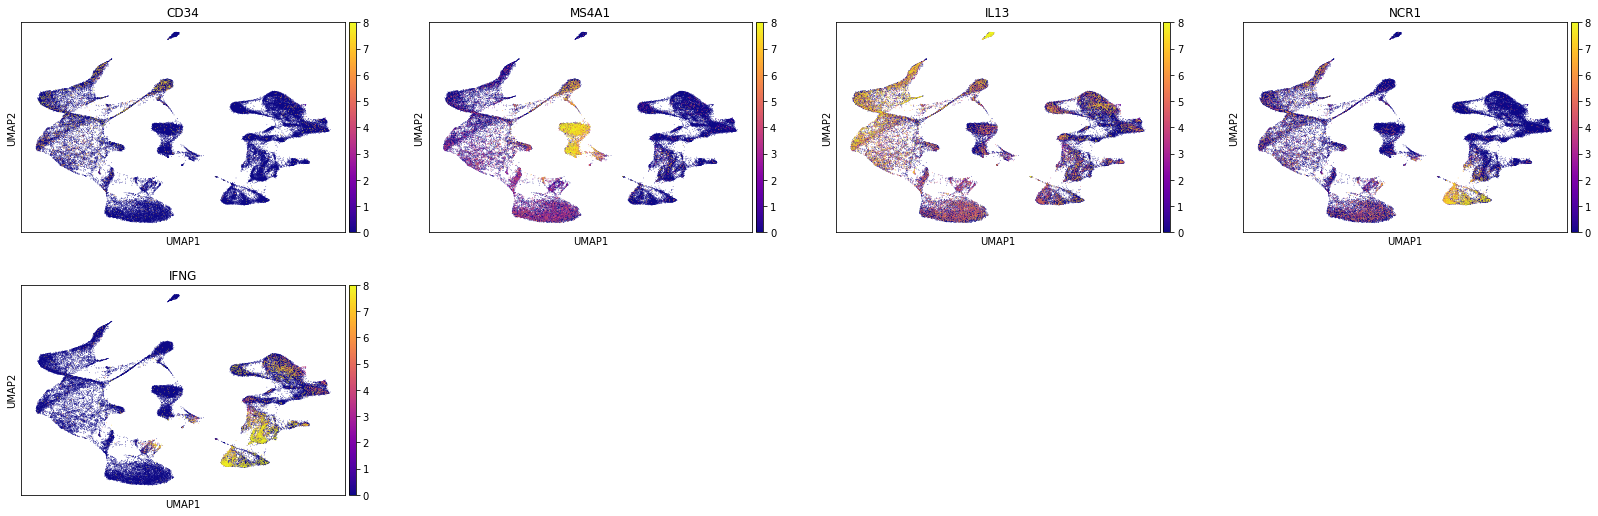

In [26]:
sc.pl.umap(newga, color=['CD34','MS4A1', 'IL13','NCR1','IFNG'],color_map='plasma', vmax=8)

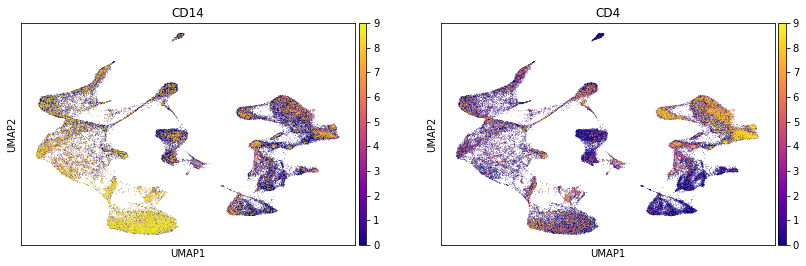

In [27]:
sc.pl.umap(newga, color=['CD14','CD4'],color_map='plasma', vmax=9)

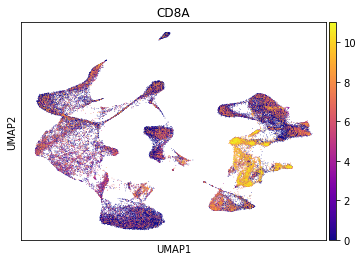

In [28]:
sc.pl.umap(newga, color='CD8A',color_map='plasma', vmax=11)

# TF footprint

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from optparse import OptionParser
from optparse import OptionGroup
import numpy as np
from utils import Mkdir
import gzip
import os

In [54]:
# separate cluster1,2,3
def filter_cluster(fragment, group, bc_cluster_dict, filtered_clusters, outprefix):
    input=gzip.open(fragment,'rb')
    output={}
    for cluster in filtered_clusters:
        output[cluster]=open(outprefix+cluster+'_fragment.bed','w')
    for line in input:
        chr,start,end,bc=line.decode().strip().split()[:4]
        #print(chr,start,end,b)
        try:
            cluster=bc_cluster_dict[bc]
            output[cluster].write('\t'.join([chr, start, end, group+'#'+bc])+'\n')
        except:
            pass
    input.close()        
    for cluster in filtered_clusters:
        output[cluster].close()     

In [42]:
CD34_df = hema[hema['Group']=='CD34_Progenitors_Rep1']
CD34_df.index=CD34_df['Barcodes']
CD34_dict=CD34_df['Clusters'].to_dict()

In [57]:
CD34_df2 = hema[hema['Group']=='CD34_Progenitors_Rep2']
CD34_df2.index=CD34_df2['Barcodes']
CD34_dict2=CD34_df2['Clusters'].to_dict()

In [55]:
filter_cluster('data/GSM3722029_CD34_Progenitors_Rep1_fragments.tsv.gz', 'CD34_Progenitors_Rep1',
              CD34_dict, ['Cluster1','Cluster2','Cluster3'], 
               'result/Hematopoiesis-All/footprint/CD34_Progenitors_Rep1_')

In [58]:
filter_cluster('data/GSM3722072_CD34_Progenitors_Rep2_fragments.tsv.gz', 'CD34_Progenitors_Rep2',
              CD34_dict2, ['Cluster1','Cluster2','Cluster3'], 
               'result/Hematopoiesis-All/footprint/CD34_Progenitors_Rep2_')

In [18]:
ref='hg19'
ref_size='/home/xionglei/yanqiu/lib/hg19.chrom.sizes'
outfootprint='result/Hematopoiesis-All/footprint'

perbase='result/Hematopoiesis-All/footprint/Cluster3_fragment.bed'
bg=perbase[:-4]+'.bedGraph'
window=500
inmotif='gata2' # motif from homer database http://homer.ucsd.edu/homer/custom.motifs
omname=outfootprint+'/'+inmotif
peaklist='data/Hematopoiesis-All/Hematopoiesis-All_peak.bed'
peakname=peaklist.split('/')[-1]
opeakname=outfootprint+'/'+peakname
imname='/home/xionglei/yanqiu/lib/Homer_motif/'+inmotif+'.motif'
outtxt=opeakname+'.'+inmotif+'_'+bg.split('/')[-1]+'.footprint'

In [ ]:
'''
export PATH=~/yanqiu/package/homer/bin:$PATH
python footprint.py \
    -r hg19 --ref_size /home/xionglei/yanqiu/lib/hg19.chrom.sizes \
    -o result/Hematopoiesis-All/footprint \
    --peak data/Hematopoiesis-All/Hematopoiesis-All_peak.bed \
    --motif gata2 \
    --perbase result/Hematopoiesis-All/footprint/Cluster1_fragment.bed 
'''    

In [230]:
def regroup(counts_matrix, n_ave=50, n_step=10, cut_off=0.7, log=True):
    # smooth along axis 1
    counts_matrix = np.asarray(counts_matrix)
    n_limit = (len(counts_matrix) - n_ave) // n_step
    ave_matrix = [counts_matrix[i*n_step:i*n_step+n_ave, :].sum(axis=0)/float(n_ave) for i in range(0, n_limit)]
    ave_matrix = np.asarray(ave_matrix)
    if log==True:
        ave_matrix = np.log(ave_matrix+1)
    max_Ave = ave_matrix.max()
    ave_matrix[np.where(ave_matrix > max_Ave*cut_off)] = max_Ave*cut_off
    return ave_matrix
    
def parse_ft(incsv,halfwidth):
    lines = open(incsv).readlines()
    length=len(lines[0].split('\t'))
    counts_matrix=pd.read_csv(incsv, sep='\t', header=0, index_col=0)
    log_ave_matrix=regroup(counts_matrix)
    #log_ave_matrix=np.log(counts_matrix+1)
    
    #nt_label = [' '] * (int(length)-1)
    #nt_label[0], nt_label[int(len(nt_label)/2)],nt_label[-1] = '-'+str(halfwidth),motifname,str(halfwidth)
    log_ave_df = pd.DataFrame(log_ave_matrix)#, index=range(0, len(log_ave_matrix)), columns=nt_label)
    return log_ave_df

def Drawfootprint(incsv,motifname,labels=None,halfwidth=250):
    plt.figure(figsize=(6, 3))
    if type(incsv)==type([]):
        colormap=plt.cm.tab10
        for i, f in enumerate(incsv):
            log_ave_df= parse_ft(f,halfwidth)
            counts=log_ave_df.sum(axis=0)
            #normalize
            counts=counts/(sum(counts[:25]+sum(counts[-25:]))/50)
            plt.plot(range(-(halfwidth), halfwidth+1),counts, color=colormap(i))
    else:
        log_ave_df= parse_ft(incsv,halfwidth)
        plt.plot(range(-(halfwidth), halfwidth+1), log_ave_df.sum(axis=0), color='firebrick')
    plt.xlim([-(halfwidth), (halfwidth)])
    plt.xticks([-halfwidth, 0, halfwidth],['-'+str(halfwidth),motifname,str(halfwidth)])
    plt.xlabel('Distance to motif')
    plt.ylabel('Insertions')
    # plt.legend()
    #plt.savefig(incsv+'.png', bbox_inches='tight')


In [222]:
incsv_list=['result/Hematopoiesis-All/footprint/Hematopoiesis-All_peak.bed.ebf_Cluster1_fragment.bedGraph.footprint',
           'result/Hematopoiesis-All/footprint/Hematopoiesis-All_peak.bed.ebf_Cluster2_fragment.bedGraph.footprint',
           'result/Hematopoiesis-All/footprint/Hematopoiesis-All_peak.bed.ebf_Cluster3_fragment.bedGraph.footprint']

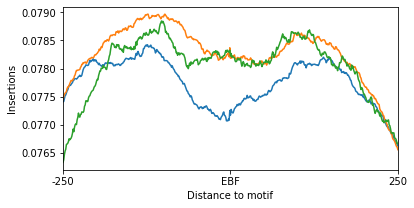

In [228]:
Drawfootprint(incsv_list,'EBF')

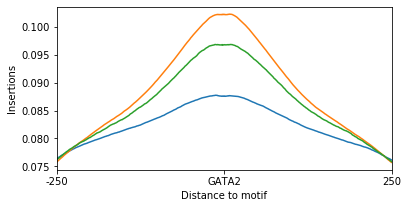

In [231]:
incsv_list=['result/Hematopoiesis-All/footprint/Hematopoiesis-All_peak.bed.gata2_Cluster1_fragment.bedGraph.footprint',
           'result/Hematopoiesis-All/footprint/Hematopoiesis-All_peak.bed.gata2_Cluster2_fragment.bedGraph.footprint',
           'result/Hematopoiesis-All/footprint/Hematopoiesis-All_peak.bed.gata2_Cluster3_fragment.bedGraph.footprint']
Drawfootprint(incsv_list,'GATA2')

# trajectory

In [44]:
adata=sc.read_h5ad('result/Hematopoiesis-All/Hematopoiesis-All_adata.h5ad')
adata.obsm['X_umap']=np.array(hema[['UMAP1','UMAP2']].loc[adata.obs_names,])

In [51]:
B_traj_cells=hema[hema['Clusters'].isin(['Cluster1','Cluster4','Cluster5','Cluster6','Cluster7','Cluster14','Cluster15','Cluster16'])]
B_traj=adata[B_traj_cells.index,]

## scanpy

In [68]:
sc.pp.neighbors(B_traj,  use_rep='X_umap')

/home/xionglei/miniconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/xionglei/miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [69]:
B_traj.uns['iroot'] = np.flatnonzero(B_traj.obs['clusters'] == "1-HSC/MPP")[0]
sc.tl.dpt(B_traj, n_branchings=1)

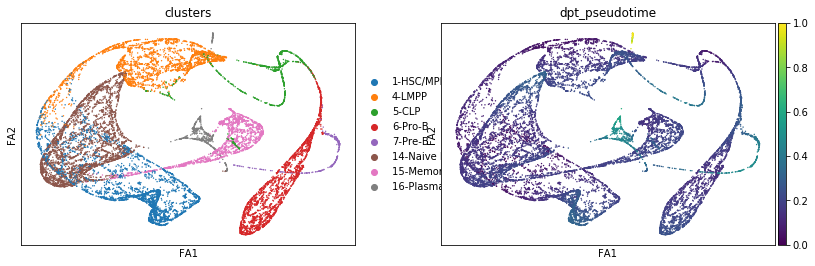

In [65]:
sc.tl.draw_graph(B_traj)
sc.pl.draw_graph(B_traj, color=['clusters','dpt_pseudotime'])

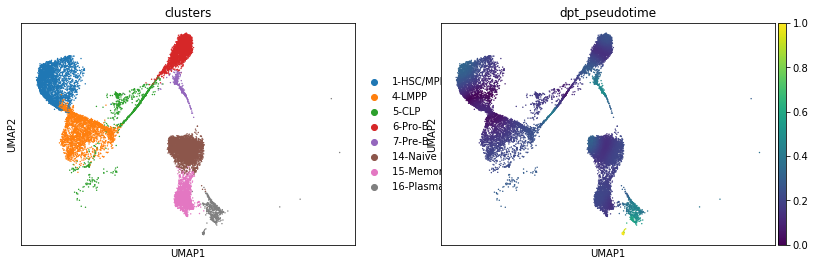

In [70]:
sc.pl.umap(B_traj, color=['clusters','dpt_pseudotime'])

In [78]:
B_traj.obs.head(5)

,UMAP1,UMAP2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,clusters,dpt_pseudotime,dpt_groups,dpt_order,dpt_order_indices
Group_Barcode,,,,,,,,,,,,,
Bone_Marrow_Rep1#CAAGAAAGTCAAGACG-1,-2.419656,7.603472,Cluster6,Bone_Marrow_Rep1,29301,0.347190,CAAGAAAGTCAAGACG-1,SUHealthy_BM_B1_50,6-Pro-B,0.219513,0,10771,2
Bone_Marrow_Rep1#CTCAGCTGTAGTACAA-1,-2.113548,5.820346,Cluster7,Bone_Marrow_Rep1,29837,0.300835,CTCAGCTGTAGTACAA-1,SUHealthy_BM_B1_66,7-Pre-B,0.467322,3,14735,14103
Bone_Marrow_Rep1#GAGCGCTGTGATCAGG-1,-10.635930,5.512935,Cluster1,Bone_Marrow_Rep1,32453,0.454503,GAGCGCTGTGATCAGG-1,SUHealthy_BM_B1_46,1-HSC/MPP,0.000000,0,0,9686
Bone_Marrow_Rep1#TGCTCACAGCGCATTT-1,-9.514290,3.969905,Cluster4,Bone_Marrow_Rep1,22296,0.471407,TGCTCACAGCGCATTT-1,SUHealthy_BM_B1_82,4-LMPP,0.053642,0,655,10700
Bone_Marrow_Rep1#ACAGGCCTCTCGCGTT-1,-1.988099,5.684596,Cluster7,Bone_Marrow_Rep1,31703,0.360171,ACAGGCCTCTCGCGTT-1,SUHealthy_BM_B1_42,7-Pre-B,0.471887,3,14753,13999


## import from trajectory.R

In [73]:
trajectory=pd.read_csv('result/Hematopoiesis-All/trajectory/trajectory_stats.txt', sep='\t', header=0, index_col=0)
cells_internal=B_traj.obs['Internal_Name'].values
B_traj.obs['trajectory_pseudotime']=(trajectory['pseudotime'][cells_internal].values)/100
head(trajectory)

,x,y,Group,pseudotime
SUHealthy_BM_B1_50,-2.419656,7.603472,Cluster6,58.468395
SUHealthy_BM_B1_66,-2.113548,5.820346,Cluster7,60.008104
SUHealthy_BM_B1_46,-10.635930,5.512935,Cluster1,15.910319


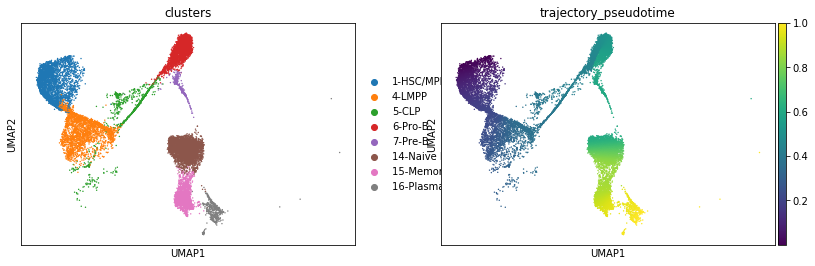

In [99]:
sc.pl.umap(B_traj, color=['clusters','trajectory_pseudotime'])

In [104]:
B_traj

AnnData object with n_obs × n_vars = 14808 × 571400 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'clusters', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'trajectory_pseudotime'
    uns: 'rank_genes_groups', 'iroot', 'neighbors', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips', 'draw_graph', 'clusters_colors', 'Clusters_colors'
    obsm: 'X_umap', 'X_diffmap', 'X_draw_graph_fa'

In [105]:
np.unique(B_traj.obs['clusters'])

array(['1-HSC/MPP', '14-Naive B', '15-Memory B', '16-Plasma cell',
       '4-LMPP', '5-CLP', '6-Pro-B', '7-Pre-B'], dtype=object)

In [ ]:
sc.tl.rank_genes_groups(B_traj, 'clusters', method='wilcoxon')
sub_gene_groups=pd.DataFrame(B_traj.uns['rank_genes_groups']['names'])
names=list(sub_gene_groups[:10].T.values.flatten())

In [163]:
names=list(sub_gene_groups[:20].T.values.flatten())

In [ ]:
B_traj.write_h5ad('result/Hematopoiesis-All/trajectory/Bcell_trajectory.h5ad')

### sc.tl.paga

In [108]:
sc.tl.paga(B_traj, groups='clusters')

In [112]:
B_traj.X=B_traj.X.todense()

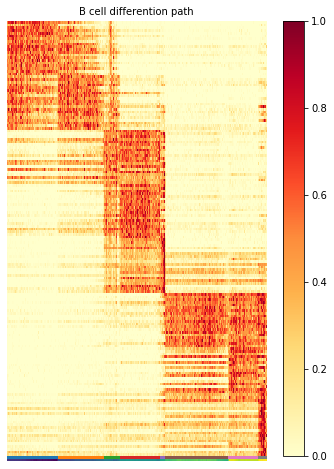

In [164]:
path=['1-HSC/MPP','4-LMPP', '5-CLP', '6-Pro-B', '7-Pre-B', '14-Naive B', '15-Memory B', '16-Plasma cell']
plt.figure(figsize=(6,8))
_, data = sc.pl.paga_path(
        B_traj, path, names,
        normalize_to_zero_one=True,
        show_node_names=False,
        left_margin=0.15,
        n_avg=50,
        annotations=['trajectory_pseudotime'],
        show_yticks=False,
        #ytick_fontsize=8,
        show_colorbar=True,
        color_map='YlOrRd',
        #color_map='RdYlBu_r',
        color_maps_annotations={'trajectory_pseudotime': 'viridis'},
        title='{} path'.format("B cell differention"),
        return_data=True,
        show=False)

### sns.heatmap

In [128]:
from plot import plot_heatmap, heatmap_smooth, scatter_traj,SmoothMat

In [123]:
# sort by pseudotime
sorted_name=B_traj.obs.sort_values('trajectory_pseudotime').index
B_traj_s=B_traj[sorted_name,]

In [303]:
#sub_gene_groups=pd.DataFrame(B_traj.uns['rank_genes_groups']['names'])
names=list(sub_gene_groups[:100].T.values.flatten())
X=pd.DataFrame(B_traj_s[:,names].X).T


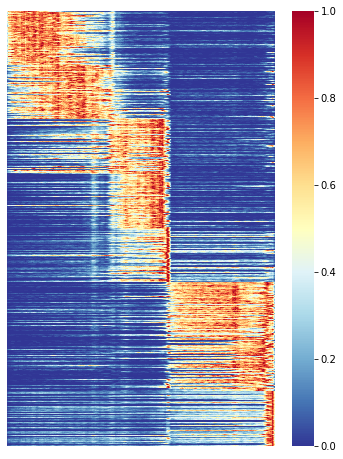

In [304]:
heatmap_smooth(X, 200)

In [308]:
B_traj_s

AnnData object with n_obs × n_vars = 14808 × 571400 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'clusters', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'trajectory_pseudotime'
    uns: 'rank_genes_groups', 'iroot', 'neighbors', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips', 'draw_graph', 'clusters_colors', 'Clusters_colors', 'paga', 'clusters_sizes'
    obsm: 'X_umap', 'X_diffmap', 'X_draw_graph_fa'

In [309]:
B_traj_s.write_h5ad('result/Hematopoiesis-All/trajectory/Bcell_trajectory_sorted.h5ad')

### tf deviation and gene activity score

In [88]:
tfdata=pd.read_csv('result/Hematopoiesis-All/chromVAR_f/hema_all_f_dev.txt', sep='\t', header=0, index_col=0)
tfdata.index=[el.split('_')[-1] for el in tfdata.index]
tfdata=sc.AnnData(tfdata.T)

In [90]:
filtered_cells=pd.read_csv('data/Hematopoiesis-All/data_filtered/barcodes.txt', header=None, index_col=0).index
tfdata.obs=hema.loc[list(filtered_cells),:]

In [92]:
tfdata

AnnData object with n_obs × n_vars = 12888 × 386 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name'

In [91]:
tfdata.write_h5ad('result/Hematopoiesis-All/chromVAR_f/tfdata.h5ad')

... storing 'Clusters' as categorical
... storing 'Group' as categorical
... storing 'Barcodes' as categorical


In [252]:
B_traj_cells=tfdata.obs[tfdata.obs['Clusters'].isin(['Cluster1','Cluster4','Cluster5','Cluster6','Cluster7','Cluster14','Cluster15','Cluster16'])]
tf_traj=tfdata[B_traj_cells.index,]
cells_internal=tf_traj.obs['Internal_Name'].values
tf_traj.obs['trajectory_pseudotime']=(trajectory['pseudotime'][cells_internal].values)/100
# sort by pseudotime
sorted_name=tf_traj.obs.sort_values('trajectory_pseudotime').index
tf_traj_s=tf_traj[sorted_name,]

Trying to set attribute `.obs` of view, copying.


In [316]:
tf_traj_s.write_h5ad('result/Hematopoiesis-All/trajectory/Bcell_tf_sorted.h5ad')

In [255]:
sc.tl.rank_genes_groups(tf_traj_s, 'clusters', method='wilcoxon')

Trying to set attribute `.uns` of view, copying.
/home/xionglei/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


In [268]:
def heatmap_smooth(X, k):
    X_smooth= X.apply(lambda x: np.convolve(x,np.ones(k),'same')/k,axis=1)
    X_smooth=pd.DataFrame(np.array(list(X_smooth)))
    X_norm=X_smooth.divide(X_smooth.max(axis=1), axis=0)
    plt.figure(figsize=(6,8))
    sns.heatmap(X_norm,cmap='RdYlBu_r',xticklabels=False, yticklabels=False,vmax=1,vmin=0)

In [260]:
names=list(pd.DataFrame(tf_traj_s.uns['rank_genes_groups']['names'])[:20].T.values.flatten())
X=pd.DataFrame(tf_traj_s[:,names].X).T

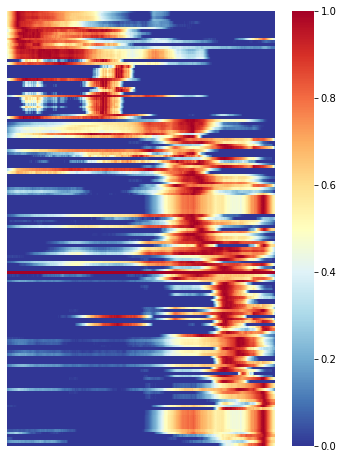

In [270]:
heatmap_smooth(X,200)

In [325]:
names=list(pd.DataFrame(tf_traj_s.uns['rank_genes_groups']['names'])[:20].T.values.flatten())
print(names.index('EBF1'))

40


In [349]:
print(names[0],names[20],names[40],names[100],names[158])

GATA1::TAL1 CEBPA EBF1 ETV6 EGR4


In [272]:
from utils import read_anndata
ga = read_anndata('result/Hematopoiesis-All/cicero/ciceroGA/')

In [281]:
overlap_names=[]

for el in names:
    if el in ga.var_names:
        overlap_names.append(el)

In [284]:
len(overlap_names)

105

In [294]:
ga_traj_filtered=ga[tf_traj_s.obs_names,overlap_names]
X=pd.DataFrame(ga_traj_filtered.X.todense()).T

In [318]:
ga_traj_filtered.write_h5ad('result/Hematopoiesis-All/trajectory/Bcell_ga_sorted.h5ad')

In [299]:
newX=np.log2(X*1000000+1)

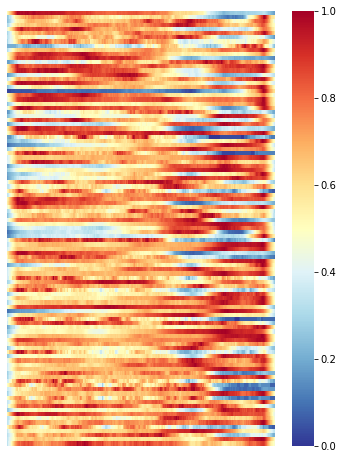

In [300]:
heatmap_smooth(newX,200)

In [ ]:
### 

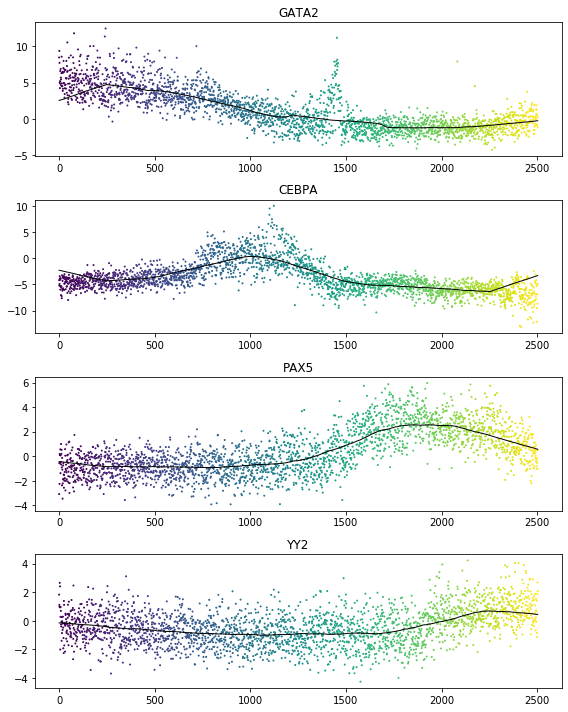

In [379]:
scatter_traj(tf_traj_s, ['GATA2','CEBPA','PAX5','YY2'])

In [320]:
tf_traj_s.var_names

Index(['NFIL3', 'FOXF2', 'FOXD1', 'IRF2', 'MZF1', 'MZF1(var.2)', 'MAX::MYC',
       'PPARG', 'Pax6', 'PBX1',
       ...
       'HOXA2', 'HOXB13', 'HOXB2', 'HOXB3', 'HOXC10', 'HOXC12', 'HOXC13',
       'HOXD11', 'HOXD13', 'ISL2'],
      dtype='object', length=386)

# CD34+

In [3]:
from utils import read_anndata
from plot import plot_embedding

In [6]:
cd34=read_anndata('data/Hematopoiesis-CD34/data')

In [128]:
cd34_cells=pd.read_csv('data/Hematopoiesis-CD34/GSE129785_scATAC-Hematopoiesis-CD34.cell_barcodes.txt.gz', 
                 sep='\t',header=0, index_col=-1)

In [16]:
cd34.obs=cd34_cells.loc[cd34.obs_names,]
cd34.obsm['X_umap']=np.array(cd34_cells[['UMAP1','UMAP2']].loc[cd34.obs_names,])
# this X-umap is wrong

In [17]:
cd34

AnnData object with n_obs × n_vars = 18489 × 571389 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name'
    obsm: 'X_umap'

In [12]:
cd34.write('result/Hematopoiesis-CD34/hema_cd34.h5ad')

... storing 'Clusters' as categorical
... storing 'Group' as categorical
... storing 'Barcodes' as categorical


## recluster with SCALE

In [20]:
scale_feature=pd.read_csv('result/Hematopoiesis-CD34/scale_cluster/feature.txt', index_col=0, header=None, sep='\t')
cluster=pd.read_csv('result/Hematopoiesis-CD34/scale_cluster/cluster_assignments.txt', index_col=0, header=None, sep='\t')

/home/xionglei/miniconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/xionglei/miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


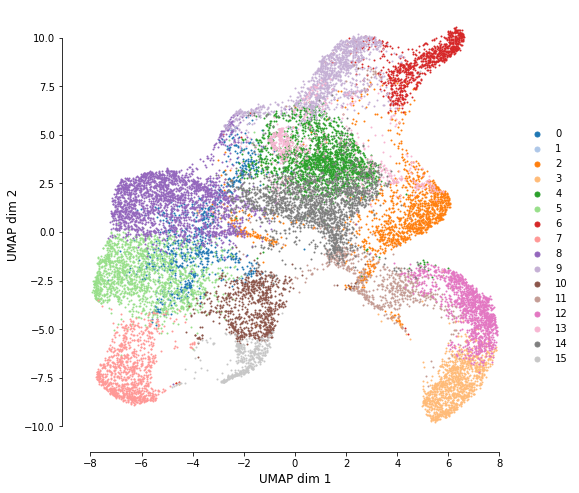

In [48]:
X_umap=plot_embedding(np.array(scale_feature), cluster[1], cmap='tab20', method = 'UMAP', return_emb=True, figsize=(8,8),markersize=1)

In [46]:
known_groups=['HSC','MPP','CMP','MEP','LMPP','CLP','GMP','BM_pDC']

In [55]:
new_group=[]
for cell in cd34.obs_names:
    if cd34.obs.loc[cell, 'Group'] in known_groups:
        new_group.append(cd34.obs.loc[cell, 'Group'])
    else:
        new_group.append('other')
cd34.obs['new_group']=new_group

Trying to set attribute `.obs` of view, copying.


In [58]:
cd34.obsm['X_umap']=X_umap

In [29]:
print(cd34.shape, cluster.shape)

(18489, 571389) (18489, 1)


In [31]:
cd34.obs['scale_cluster']=cluster.loc[cd34.obs_names][1]

In [32]:
cd34

AnnData object with n_obs × n_vars = 18489 × 571389 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'new_group', 'scale_cluster'
    obsm: 'X_umap'

In [46]:
cd34.write('result/Hematopoiesis-CD34/hema_cd34.h5ad')

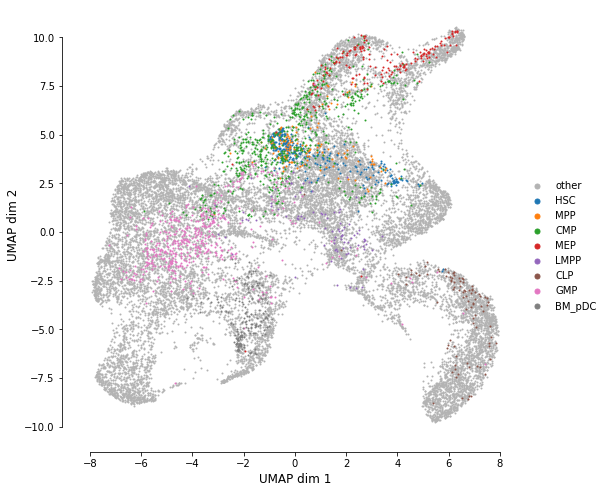

In [63]:
plot_embedding(cd34.obsm['X_umap'], cd34.obs['new_group'], classes=['other']+known_groups,
               custom_cmap=[(0.7,0.7,0.7)]+sns.color_palette('tab10', len(known_groups)), 
               method = 'UMAP', figsize=(8,8),markersize=1)

In [66]:
np.savetxt('result/Hematopoiesis-CD34/scale_cluster/umap.txt',X_umap)

In [25]:
cd34=sc.read_h5ad('result/Hematopoiesis-CD34/hema_cd34.h5ad')

In [70]:
cd34

AnnData object with n_obs × n_vars = 18489 × 571389 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'new_group'
    obsm: 'X_umap'

In [38]:
## generate confusion matrix
df=cd34.obs
cm=df[df['new_group']!='other'].groupby(['scale_cluster','Group']).size()
cm_df=pd.DataFrame(cm)
cm_df.reset_index(inplace=True)
new_df=cm_df.pivot(index='scale_cluster', columns='Group', values=0)
new_df=new_df.fillna(0)

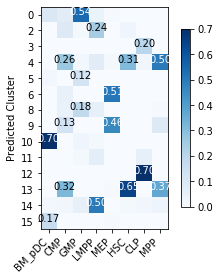

In [47]:
plot_confusion_matrix(np.array(new_df),x_classes=new_df.columns, y_classes=new_df.index,
                      normalize=True,figsize=(4,4))

In [86]:
sorted_x_classes=['HSC','MPP','CMP','MEP','LMPP','CLP','GMP','BM_pDC']
sorted_y_classes=[13,4,9,6,2,14,11,3,12,5,8,0,15,10]
X=new_df.loc[sorted_y_classes, sorted_x_classes]

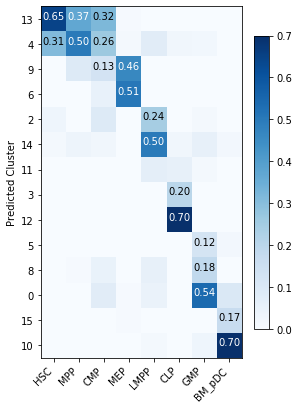

In [87]:
plot_confusion_matrix(np.array(X), x_classes=X.columns, y_classes=X.index,
                      normalize=True,figsize=(4,6))

## traj

In [96]:
from plot import heatmap_smooth

In [ ]:
tfdata=sc.read_h5ad('result/Hematopoiesis-All/chromVAR_f/tfdata.h5ad')

In [139]:
tfdata

AnnData object with n_obs × n_vars = 12888 × 386 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'scale_cluster'

In [ ]:
intersect_cells=[]
for cell in cd34_cells.index:
    if cell in tfdata.obs_names:
        intersect_cells.append(cell)

In [134]:
tfdata_cd34=tfdata[intersect_cells,]

In [154]:
cluster=pd.read_csv('result/Hematopoiesis-CD34/scale_cluster/cluster_assignments.txt', index_col=0, header=None, sep='\t')
tfdata_cd34.obs['scale_cluster']=cluster.loc[tfdata_cd34.obs_names,:][1].astype('category')

In [98]:
# plot heatmap
## choose 250 most variable TFs
var = pd.read_csv('result/Hematopoiesis-All/chromVAR_f/hema_all_f_var.txt', sep='\t', header=0, index_col=0)
var = var [var['p_value_adj']<0.05]
var_sort = var.sort_values(by='variability',ascending=False)
tf_filtered = [el.split('_')[-1] for el in var_sort.index][:250]
tfdata_f = tfdata[:,tf_filtered]

In [176]:
def draw_traj(tfdata, lineage, clusters, smooth_k=200):
    trajectory=pd.read_csv('result/Hematopoiesis-CD34/trajectory/%s_trajectory_stats.txt'%lineage, 
                           sep='\t', header=0, index_col=0)
    traj_cells=tfdata.obs[tfdata.obs['scale_cluster'].isin(clusters)]
    tf_traj=tfdata[traj_cells.index,]
    cells_internal=tf_traj.obs['Internal_Name'].values
    tf_traj.obs['trajectory_pseudotime']=(trajectory['pseudotime'][cells_internal].values)/100

    # sort by pseudotime
    sorted_name=tf_traj.obs.sort_values('trajectory_pseudotime').index
    tf_traj_s=tf_traj[sorted_name,]
    
    sc.tl.rank_genes_groups(tf_traj, 'scale_cluster', method='wilcoxon')
    sub_gene_groups=pd.DataFrame(tf_traj.uns['rank_genes_groups']['names'])
    clusters_i=[]
    for el in clusters:
        if str(el) in sub_gene_groups.columns:
            clusters_i.append(str(el))
    sub_gene_groups=sub_gene_groups[clusters_i]
    names=list(sub_gene_groups[:20].T.values.flatten())

    X=pd.DataFrame(tf_traj_s[:,names].X).T
    heatmap_smooth(X,smooth_k)

Trying to set attribute `.obs` of view, copying.
/home/xionglei/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


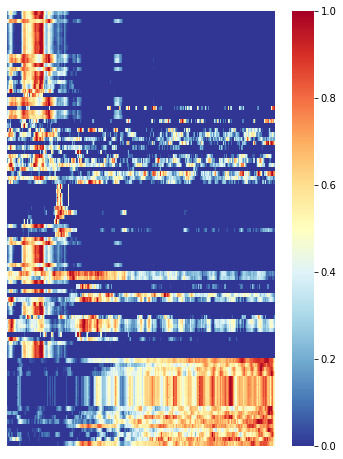

In [187]:
draw_traj(tfdata_cd34, 'B',[13,4,14,11,12,3], smooth_k=10)

Trying to set attribute `.obs` of view, copying.


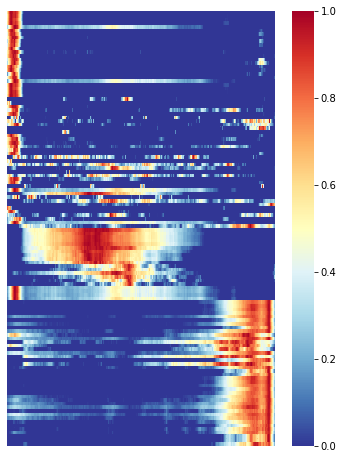

In [189]:
draw_traj(tfdata_cd34, 'pDC1',[13,4,0,5,10,15], smooth_k=50)

Trying to set attribute `.obs` of view, copying.


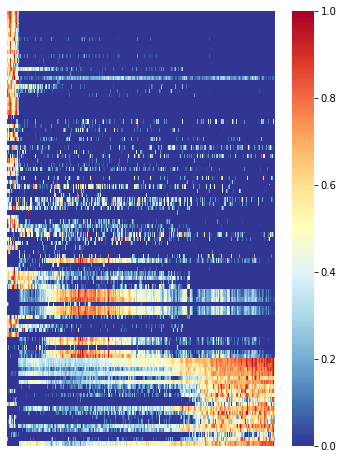

In [193]:
draw_traj(tfdata_cd34, 'pDC2',[13,4,0,5,7], smooth_k=10)

Trying to set attribute `.obs` of view, copying.


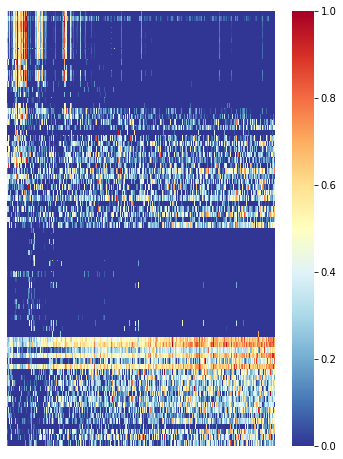

In [199]:
draw_traj(tfdata_cd34, 'Meg',[13,4,9,6], smooth_k=2)